# Importing packages

In [9]:
import os
from torch.nn.utils.rnn import pad_sequence
from torch.profiler import profile, record_function, ProfilerActivity
from absl import logging
import cv2
import mediapipe as mp
import numpy as np
from pathlib import Path
import cv2
import torch
import os
import cv2
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, TensorDataset, DataLoader
from pathlib import Path
import mediapipe as mp
import subprocess
from typing import List, Dict, Tuple
import re
import random
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import AdamW
import fairseq
import fairseq.models
from fairseq.models import MODEL_REGISTRY
from tqdm import tqdm
from fairseq import checkpoint_utils, options, tasks, utils
from fairseq.dataclass.configs import GenerationConfig
from IPython.display import HTML
from argparse import Namespace
import torch.nn.functional as F
import av_hubert.avhubert
import sentencepiece as spm
from torch.serialization import safe_globals
from fairseq.data.dictionary import Dictionary
from torch.utils.tensorboard import SummaryWriter
import fairseq.criterions.ctc as ctc
from jiwer import wer
import string
from collections import Counter

# Data preparation

In [10]:
# Creating path variables
audio_files_path = Path("audio_files")
transcriptions_path = Path("transcriptions")
models_path = Path("models")
video_files_path = Path("video_files")
transcriptions_paths = [file for file in transcriptions_path.iterdir() if file.is_file()]

### Training sentencepiece model
Training model for splitting words into subwords

In [11]:
def parse_srt_transcript(transcript_path):
        """Parses an .srt file and returns a list of words in order."""
        words = []
        with open(transcript_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()

        for line in lines:
            line = line.strip()
            if not re.match(r"^\d+$", line) and "-->" not in line and line:
                words.append(line.lower())

        return words

In [12]:
def train_sentencepiece(transcripts, vocab_size=1000):
        """Trains SentencePiece model on the transcripts and returns subword to index dictionary."""
        temp_file = "temp_corpus.txt"
        with open(temp_file, "w", encoding="utf-8") as f:
            for transcript in transcripts:
                words = parse_srt_transcript(transcript)
                chunk_size = 20  # Number of words per line
                chunks = [" ".join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)]
                for chunk in chunks:
                    f.write(chunk + "\n")
        
        spm.SentencePieceTrainer.train(input=temp_file, model_prefix="sp_model", vocab_size=vocab_size, model_type="bpe", hard_vocab_limit=False)
        sp = spm.SentencePieceProcessor(model_file="sp_model.model")
        # Create dictionary of subwords and their corresponding indices
        subword_to_idx = {sp.id_to_piece(i): i for i in range(sp.get_piece_size())}

        return sp, subword_to_idx

In [5]:
# Training sentencepiece model for subwords
x = train_sentencepiece([transcriptions_path / "geologia 1.srt",
                    transcriptions_path / "geologia 2.srt",
                    transcriptions_path / "geologia_3.srt",
                    transcriptions_path / "geologia_4.srt",
                    transcriptions_path / "geologia 5.srt",
                    transcriptions_path / "geologia 6.srt",
                    transcriptions_path / "geologia 7.srt",
                    transcriptions_path / "geologia 8.srt",
                    transcriptions_path / "geologia 9.srt",
                    transcriptions_path / "geologia 10.srt"])

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: temp_corpus.txt
  input_format: 
  model_prefix: sp_model
  model_type: BPE
  vocab_size: 1000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 0
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_wh

# Dataset classes
Two dataset classes created for testing purposes. 

First class DynamicAVHubertDatasetFrames, which outputs every 5th frame from video(to reduce dataset size without loosing meaningfull information) and corresponding subword. This class is used for training with CrossEntropy Loss, which needs precise alignment. 

Second class DynamicAVHubertDataset which outputs 5 seconds chunks for each created class instance and corresponding transcription chunk. This class is used for training with Ctc Loss, which doesn't need precise alignemnt, however it needs video and transcription sizes. 

AVHubert was originally trained using Ctc Loss, but for testing purpuses CrossEntropy Loss was also tested. 

Pipelines for both functions work in a simmilar way. 
For DynamicAVHubertDatasetFrames class subwords are generated dynamically by splitting transcript words proportionally to their duration based on SentencePiece tokenization. Each frame is matched to its corresponding subword using exact timestamps. To extract features, frames are sampled using ffmpeg at given timestamps, the mouth region is localized using MediaPipe FaceMesh, and the region of interest is resized to a fixed size. Some simple augmentations such as horizontal flipping, brightness and contrast changes can also be applied.

For DynamicAVHubertDataset class, for each chunk, frames are extracted at a fixed frame rate, mouth regions are cropped using MediaPipe, and features are stacked into a tensor. Transcriptions are split into subwords using SentencePiece, and the corresponding subword segment for the video chunk is selected based on timing information. Chunk extraction is randomized during training to improve generalization. This class closely follows the original AVHubert training setup, where longer segments and CTC-based training were used.


In [281]:
class DynamicAVHubertDatasetFrames(Dataset):
    def __init__(self, video_paths, transcript_paths, sp_model, roi_size=(112, 112), fps=25, frame_interval=5):
        """
        Args:
            video_paths: List of video file paths
            transcript_paths: List of transcript file paths
            sp_model: SentencePiece model
            roi_size: Size of mouth ROI
            fps: Original video frames per second
            frame_interval: Use every Nth frame (e.g., 5 means 5fps from 25fps)
        """
        self.video_paths = video_paths
        self.transcript_paths = transcript_paths
        self.roi_size = roi_size
        self.sp = sp_model
        self.original_fps = fps
        self.frame_interval = frame_interval
        self.effective_fps = fps / frame_interval
        self.frame_duration = 1.0 / self.effective_fps

        assert len(video_paths) == len(transcript_paths), "Video and transcript lists must match"
        assert fps % frame_interval == 0, "FPS should be divisible by frame interval"

        self.entries = []
        self.frame_indices = []  # Stores (entry_idx, frame_idx) tuples
        
        # Parse each video and transcript
        for entry_idx, (video_path, transcript_path) in enumerate(zip(video_paths, transcript_paths)):
            word_data = self._parse_srt_with_timings(transcript_path)
            duration = self._get_video_duration(video_path)
            width = self._get_video_width(video_path)
            height = self._get_video_height(video_path)
            
            subword_data = self._process_word_data_to_subwords(word_data)
            
            self.entries.append({
                'video_path': video_path,
                'subword_data': subword_data,
                'duration': duration,
                'width': width,
                'height': height
            })
            
            # Calculate frame indices for this video
            total_frames = int(duration * self.original_fps)
            for frame_idx in range(0, total_frames, self.frame_interval):
                self.frame_indices.append((entry_idx, frame_idx))

        # MediaPipe setup
        self.face_mesh = mp.solutions.face_mesh.FaceMesh(
            static_image_mode=False,
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.4
        )
        self.mouth_landmarks = [
            61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
            291, 375, 321, 405, 314, 17, 84, 181, 91, 146
        ]
        
    
    def __len__(self):
        return len(self.frame_indices)

    def __getitem__(self, idx):
        entry_idx, frame_idx = self.frame_indices[idx]
        entry_data = self.entries[entry_idx]

        # Calculate timestamp for this frame
        original_frame_time = frame_idx / self.original_fps
        frame_time = idx * self.frame_duration  # More precise timing
        
        frame = self._extract_single_frame(
            entry_data['video_path'],
            original_frame_time,
            entry_data['width'],
            entry_data['height']
        )


        if frame is None:
            return {
                'video': torch.zeros((1, *self.roi_size)),
                'text': self.sp.pad_id()  # or appropriate blank token
            }
        
        subword = self._find_subword_for_frame(entry_data['subword_data'], frame_time)
        token = self.sp.encode(subword, out_type=int)
        token = [t for t in token if t != self.sp.piece_to_id('▁')]
        
        return {
            'video': torch.from_numpy(frame).float() / 255.0,
            'text': token[0] if len(token) > 0 else self.sp.pad_id()
        }


    def _augment_mouth_roi(self, roi):
        # roi: np.array shape (1, H, W) — grayscale
        if random.random() < 0.3:
            roi = np.flip(roi, axis=2)  # Horizontal flip
        if random.random() < 0.3:
            #roi = roi + np.random.normal(0, 5, roi.shape)  # Gaussian noise
            roi = np.clip(roi, 0, 255)
        if random.random() < 0.3:
            alpha = random.uniform(0.8, 1.2)  # Contrast
            beta = random.uniform(0, 10)    # Brightness
            roi = np.clip(alpha * roi + beta, 0, 255)
        return roi

    def _find_video_and_frame(self, global_frame_idx):
        """Find which video and which frame withind that video corresponds to the global frame index"""
        current_frame = 0
        for video_idx, entry in enumerate(self.entries):
            video_frames = int(entry['duration'] * self.fps)
            if global_frame_idx < current_frame + video_frames:
                return video_idx, global_frame_idx - current_frame
            current_frame += video_frames
        return 0, 0  # fallback

    def _extract_single_frame(self, video_path, timestamp, width, height):
        """Extract a single frame at the specified timestamp"""
        cmd = [
            'ffmpeg', '-ss', str(timestamp), '-i', str(video_path),
            '-vframes', '1',  # Just get one frame
            '-f', 'image2pipe', '-pix_fmt', 'rgb24',
            '-vcodec', 'rawvideo', '-'
        ]
        try:
            pipe = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            raw = pipe.stdout.read(width * height * 3)
            pipe.terminate()

            if not raw:
                return None

            frame = np.frombuffer(raw, dtype=np.uint8).reshape((height, width, 3))
            #plt.imshow(frame[0], cmap='grey')
            
            mouth_roi = self._extract_mouth_roi(frame, width, height)
            return mouth_roi
        except Exception as e:
            print(f"Error extracting frame: {e}")
            return None

    def _find_subword_for_frame(self, subword_data, frame_time):
        """Find the subword that corresponds to the given frame time"""
        for subword in subword_data:
            if subword['start'] <= frame_time < subword['end']:
                return subword['text']
        return "<space>"  # Return space token if no subword found

    def _process_word_data_to_subwords(self, word_data):
        """Convert word-level timings to subword-level timings"""
        subword_data = []
        
        for word in word_data:
            word_text = word['text']
            start_time = word['start']
            end_time = word['end']
            word_duration = end_time - start_time
            
            # Encode the word into subwords
            subwords = self.sp.encode_as_pieces(word_text)
            num_subwords = len(subwords)
            
            if num_subwords == 0:
                continue  # Skip empty words
                
            # Calculate the total length of all subwords in characters
            total_subword_length = sum(len(subword.replace("▁", "")) for subword in subwords)
            
            # Distribute the word's duration proportionally to the length of each subword
            original_start_time = start_time
            for subword in subwords:
                subword_duration = word_duration * (len(subword.replace("▁", "")) / total_subword_length)
                subword_end = start_time + subword_duration
                
                subword_data.append({
                    'text': subword,
                    'start': start_time,
                    'end': subword_end
                })
                # Update the start time for the next subword
                start_time = subword_end
                
        return subword_data

    def _parse_srt_with_timings(self, srt_path):
        """Parse the SRT file into word-level timings"""
        with open(srt_path, 'r', encoding='utf-8') as f:
            lines = [line.strip() for line in f.readlines() if line.strip()]

        word_data = []
        i = 0
        while i < len(lines):
            if re.match(r"\d+:\d+:\d+,\d+ --> \d+:\d+:\d+,\d+", lines[i]):
                start, end = lines[i].split(' --> ')
                start_sec = self._srt_time_to_seconds(start.strip())
                end_sec = self._srt_time_to_seconds(end.strip())
                
                # Get all text lines until next timestamp or empty line
                i += 1
                text_lines = []
                while i < len(lines) and not re.match(r"(\d+:\d+:\d+,\d+ -->|^\d+$)", lines[i]):
                    text_lines.append(lines[i])
                    i += 1
                
                # Split into words with original timings
                if text_lines:
                    full_text = ' '.join(text_lines)
                    words = full_text.split()
                    word_duration = (end_sec - start_sec) / len(words)
                    
                    for j, word in enumerate(words):
                        word_data.append({
                            'text': word.lower(),
                            'start': start_sec + j * word_duration,
                            'end': start_sec + (j + 1) * word_duration
                        })
            else:
                i += 1

        return word_data

    def _srt_time_to_seconds(self, time_str):
        """Convert SRT timestamp to seconds"""
        hh_mm_ss, ms = time_str.split(',')  # hh:mm:ss,xxx
        h, m, s = hh_mm_ss.split(':')
        return int(h) * 3600 + int(m) * 60 + int(s) + int(ms) / 1000

    def _get_video_duration(self, video_path):
        """Get video duration in seconds using ffprobe"""
        cmd = [
            'ffprobe', '-i', str(video_path),
            '-show_entries', 'format=duration',
            '-v', 'quiet', '-of', 'csv=p=0'
        ]
        try:
            duration = float(subprocess.check_output(cmd).decode().strip())
            return duration
        except Exception as e:
            print(f"Error getting duration: {e}")
            return 0.0  # Fallback value

    def _get_video_width(self, video_path):
        """Get video width using ffprobe"""
        cmd = [
            'ffprobe', '-v', 'error', '-select_streams', 'v:0',
            '-show_entries', 'stream=width', '-of', 'csv=p=0', str(video_path)
        ]
        return int(subprocess.check_output(cmd).decode().strip())

    def _get_video_height(self, video_path):
        """Get video height using ffprobe"""
        cmd = [
            'ffprobe', '-v', 'error', '-select_streams', 'v:0',
            '-show_entries', 'stream=height', '-of', 'csv=p=0', str(video_path)
        ]
        return int(subprocess.check_output(cmd).decode().strip())

    def _extract_mouth_roi(self, frame, width, height):
        """Extract the mouth ROI from a frame"""
        results = self.face_mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        #plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if not results.multi_face_landmarks:
            return None
    
        landmarks = results.multi_face_landmarks[0].landmark
        mouth_points = np.array([(landmarks[i].x, landmarks[i].y) 
                                for i in self.mouth_landmarks])
    
        # Dynamic bounding box with padding
        x_min, y_min = mouth_points.min(axis=0)
        x_max, y_max = mouth_points.max(axis=0)
        w, h = x_max - x_min, y_max - y_min
        padding = max(w, h) * 0.2  # 20% padding
        
        # Convert to pixel coordinates
        x_min = int(max(0, (x_min - padding) * width))
        y_min = int(max(0, (y_min - padding) * height))
        x_max = int(min(width, (x_max + padding) * width))
        y_max = int(min(height, (y_max + padding) * height))
        
        # Extract and resize
        mouth_roi = frame[y_min:y_max, x_min:x_max]
        if mouth_roi.size == 0:
            return None

        mouth_roi = cv2.cvtColor(mouth_roi, cv2.COLOR_BGR2GRAY)  # -> (H, W)
        mouth_roi = cv2.resize(mouth_roi, self.roi_size)         # -> (H, W)
        mouth_roi = np.expand_dims(mouth_roi, axis=0) 
        return mouth_roi

I0000 00:00:1745663551.028430  860211 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1745663551.079197 2063231 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA A10/PCIe/SSE2


{'video': tensor([[[0.3647, 0.3725, 0.4000,  ..., 0.4078, 0.4078, 0.4078],
         [0.3647, 0.3725, 0.4000,  ..., 0.4078, 0.4078, 0.4078],
         [0.3686, 0.3765, 0.4000,  ..., 0.4118, 0.4078, 0.4078],
         ...,
         [0.4706, 0.4667, 0.4588,  ..., 0.5294, 0.5294, 0.5294],
         [0.4706, 0.4667, 0.4588,  ..., 0.5294, 0.5294, 0.5294],
         [0.4706, 0.4667, 0.4588,  ..., 0.5294, 0.5294, 0.5294]]]), 'text': 255}


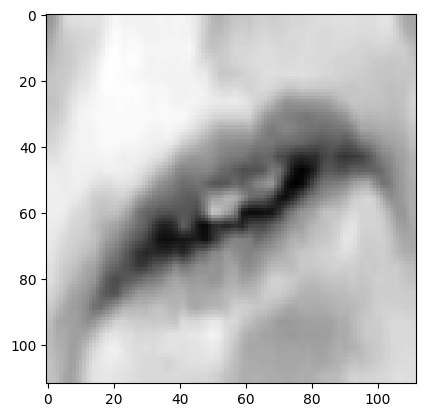

In [310]:
test_frames_dataset = train_dataset = DynamicAVHubertDatasetFrames(
    video_paths=[video_files_path / "train_1min.mp4"],
    transcript_paths=[transcriptions_path / "train 1min.srt"],
    sp_model=sp
)
test_sample = test_frames_dataset[100]
print(test_sample)
plt.imshow(test_sample["video"][0], cmap='grey')

In [312]:
class DynamicAVHubertDataset(Dataset):
    def __init__(self, video_paths, transcript_paths, sp_model, chunk_size=5.0, roi_size=(112, 112), deterministic=False):
        self.video_paths = video_paths
        self.transcript_paths = transcript_paths
        self.chunk_size = chunk_size
        self.roi_size = roi_size
        self.sp = sp_model
        self.deterministic = deterministic
        self.chunk_indices = []
        
        # Check if the lengths of both lists match
        assert len(video_paths) == len(transcript_paths), "Video and transcript lists must have the same length."

        self.entries = []
        
        # Parse each video and transcript
        for entry_idx, (video_path, transcript_path) in enumerate(zip(video_paths, transcript_paths)):
            word_data = self._parse_srt_with_timings(transcript_path)
            duration = self._get_video_duration(video_path)
            width = self._get_video_width(video_path)
            height = self._get_video_height(video_path)
            
            self.entries.append({
                'video_path': video_path,
                'transcript_path': transcript_path,
                'word_data': word_data,
                'duration': duration,
                'width': width,
                'height': height
            })

            num_chunks = int(duration//self.chunk_size)
            if deterministic:
                for i in range(num_chunks):
                    self.chunk_indices.append((entry_idx, i * self.chunk_size))
        # MediaPipe setup
        self.face_mesh = mp.solutions.face_mesh.FaceMesh(
            static_image_mode=False,
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.5
        )
        self.mouth_landmarks = [
            61, 185, 40, 39, 37, 0, 267, 269, 270, 409,  # Outer lips
            291, 375, 321, 405, 314, 17, 84, 181, 91, 146  # Inner mouth
        ]
    
    def __len__(self):
        """Returns the total number of valid chunks across all videos"""
        if self.deterministic:
            return len(self.chunk_indices)
        return sum(int(entry['duration'] // self.chunk_size) for entry in self.entries)

    def __getitem__(self, idx):
        """Returns a random sample from one of the video-transcript pairs"""
        if self.deterministic:
            entry_idx, start_time = self.chunk_indices[idx]
            entry_data = self.entries[entry_idx]
        else:
            entry_data = random.choice(self.entries)
            duration = entry_data['duration']
            start_time = random.uniform(0, duration - self.chunk_size)

        end_time = start_time + self.chunk_size
        # Extract frames for the chunk
        frames = self._extract_frames(entry_data['video_path'], start_time, end_time, entry_data['width'], entry_data['height'])
        
        if len(frames) < 10:  # Minimum 10 frames
            if self.deterministic:
                return self.__getitem__(idx+1)
            return self.__getitem__(random.randint(0, len(self) - 1))  # Retry with a new index

        # Find the corresponding words in the transcript for this chunk
        word_data = entry_data['word_data']
        chunk_words = []
        for word in word_data:
            if word['start'] >= start_time and word['end'] <= end_time:
                chunk_words.append(word['text'])

        # Remove punctuation from the words
        clean_text = " ".join(chunk_words)
        clean_text = re.sub(r'[^\w\s]', '', clean_text)  # Remove punctuation
        
        # Tokenize the word and prepare the text for the model
        tokens = self.sp.encode(clean_text, out_type=str)
        text = " ".join(tokens)

        total_video_duration = sum(entry['duration'] for entry in self.entries)
        total_chunks = total_video_duration / self.chunk_size

        return {
            'video': torch.stack([torch.from_numpy(f).float() / 255.0 for f in frames]),  # (T, 3, H, W)
            'text': text,
            'length': len(frames)
        }

    def _get_video_duration(self, video_path):
        """Get video duration in seconds using ffprobe"""
        cmd = [
            'ffprobe', '-i', str(video_path),
            '-show_entries', 'format=duration',
            '-v', 'quiet', '-of', 'csv=p=0'
        ]
        try:
            duration = float(subprocess.check_output(cmd).decode().strip())
            return duration
        except Exception as e:
            print(f"Error getting duration: {e}")
            return 0.0  # Fallback value

    def _get_video_width(self, video_path):
        """Get video width using ffprobe"""
        cmd = [
            'ffprobe', '-v', 'error', '-select_streams', 'v:0',
            '-show_entries', 'stream=width', '-of', 'csv=p=0', str(video_path)
        ]
        return int(subprocess.check_output(cmd).decode().strip())

    def _get_video_height(self, video_path):
        """Get video height using ffprobe"""
        cmd = [
            'ffprobe', '-v', 'error', '-select_streams', 'v:0',
            '-show_entries', 'stream=height', '-of', 'csv=p=0', str(video_path)
        ]
        return int(subprocess.check_output(cmd).decode().strip())

    def _extract_frames(self, video_path, start_time, end_time, width, height):
        """Extract frames for the given time range"""
        cmd = [
            'ffmpeg', '-ss', str(start_time), '-i', str(video_path),
            '-t', str(end_time - start_time), '-r', '25',  # 25 FPS
            '-f', 'image2pipe', '-pix_fmt', 'rgb24',
            '-vcodec', 'rawvideo', '-'
        ]
        pipe = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        frames = []
    
        while True:
            raw = pipe.stdout.read(width * height * 3)
            if not raw:
                break
            frame = np.frombuffer(raw, dtype=np.uint8).reshape((height, width, 3))
            
            # Now pass width and height to _extract_mouth_roi
            mouth_roi = self._extract_mouth_roi(frame, width, height)
            if mouth_roi is not None:
                frames.append(mouth_roi)
        
        pipe.terminate()
        return frames

    def _extract_mouth_roi(self, frame, width, height):
        """Extract the mouth ROI from a frame"""
        results = self.face_mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if not results.multi_face_landmarks:
            return None
    
        landmarks = results.multi_face_landmarks[0].landmark
        mouth_points = np.array([(landmarks[i].x, landmarks[i].y) 
                                for i in self.mouth_landmarks])
    
        # Dynamic bounding box with padding
        x_min, y_min = mouth_points.min(axis=0)
        x_max, y_max = mouth_points.max(axis=0)
        w, h = x_max - x_min, y_max - y_min
        padding = max(w, h) * 0.2  # 20% padding
        
        # Convert to pixel coordinates
        x_min = int(max(0, (x_min - padding) * width))
        y_min = int(max(0, (y_min - padding) * height))
        x_max = int(min(width, (x_max + padding) * width))
        y_max = int(min(height, (y_max + padding) * height))
        
        # Extract and resize
        mouth_roi = frame[y_min:y_max, x_min:x_max]
        if mouth_roi.size == 0:
            return None

        mouth_roi = cv2.cvtColor(mouth_roi, cv2.COLOR_BGR2GRAY)  # -> (H, W)
        mouth_roi = cv2.resize(mouth_roi, self.roi_size)         # -> (H, W)
        mouth_roi = np.expand_dims(mouth_roi, axis=0) 
        return mouth_roi

    def _parse_srt_with_timings(self, srt_path):
        """Parse the SRT file into word-level timings"""
        with open(srt_path, 'r', encoding='utf-8') as f:
            lines = [line.strip() for line in f.readlines() if line.strip()]

        word_data = []
        i = 0
        while i < len(lines):
            if re.match(r"\d+:\d+:\d+,\d+ --> \d+:\d+:\d+,\d+", lines[i]):
                start, end = lines[i].split(' --> ')
                start_sec = self._srt_time_to_seconds(start.strip())
                end_sec = self._srt_time_to_seconds(end.strip())
                
                # Get all text lines until next timestamp or empty line
                i += 1
                text_lines = []
                while i < len(lines) and not re.match(r"(\d+:\d+:\d+,\d+ -->|^\d+$)", lines[i]):
                    text_lines.append(lines[i])
                    i += 1
                
                # Split into words with original timings
                if text_lines:
                    full_text = ' '.join(text_lines)
                    words = full_text.split()
                    word_duration = (end_sec - start_sec) / len(words)
                    
                    for j, word in enumerate(words):
                        word_data.append({
                            'text': word.lower(),
                            'start': start_sec + j * word_duration,
                            'end': start_sec + (j + 1) * word_duration
                        })
            else:
                i += 1

        return word_data

    def _srt_time_to_seconds(self, time_str):
        """Convert SRT timestamp to seconds"""
        hh_mm_ss, ms = time_str.split(',')  # hh:mm:ss,xxx
        h, m, s = hh_mm_ss.split(':')
        return int(h) * 3600 + int(m) * 60 + int(s) + int(ms) / 1000

I0000 00:00:1745663716.485732  860211 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1745663716.536691 2065130 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA A10/PCIe/SSE2


{'video': tensor([[[[0.4314, 0.4314, 0.4314,  ..., 0.4431, 0.4392, 0.4392],
          [0.4314, 0.4314, 0.4314,  ..., 0.4392, 0.4392, 0.4392],
          [0.4314, 0.4314, 0.4314,  ..., 0.4392, 0.4392, 0.4392],
          ...,
          [0.3961, 0.3961, 0.3961,  ..., 0.4784, 0.4745, 0.4745],
          [0.3961, 0.3961, 0.3961,  ..., 0.4784, 0.4745, 0.4745],
          [0.3961, 0.3961, 0.3961,  ..., 0.4784, 0.4745, 0.4745]]],


        [[[0.3373, 0.3451, 0.3608,  ..., 0.4000, 0.3961, 0.3961],
          [0.3373, 0.3451, 0.3608,  ..., 0.4000, 0.3961, 0.3961],
          [0.3373, 0.3451, 0.3608,  ..., 0.4039, 0.4000, 0.4000],
          ...,
          [0.4706, 0.4667, 0.4627,  ..., 0.4941, 0.4824, 0.4784],
          [0.4706, 0.4667, 0.4627,  ..., 0.4941, 0.4824, 0.4784],
          [0.4706, 0.4667, 0.4627,  ..., 0.4941, 0.4824, 0.4784]]],


        [[[0.4863, 0.4745, 0.4549,  ..., 0.4471, 0.4667, 0.4745],
          [0.4863, 0.4745, 0.4549,  ..., 0.4471, 0.4667, 0.4745],
          [0.4824, 0.4706, 0

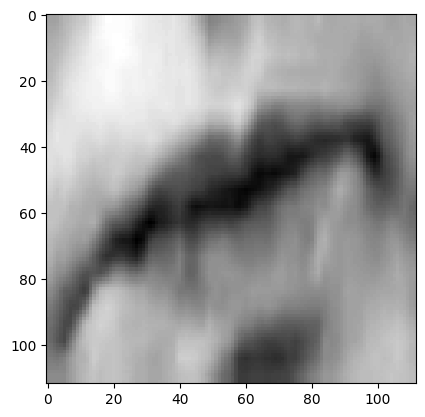

In [316]:
test_dataset = DynamicAVHubertDataset(
    video_paths=[video_files_path / "train_1min.mp4"],
    transcript_paths=[transcriptions_path / "train 1min.srt"],
    sp_model=sp,
    deterministic=True,
    chunk_size=5
)
test_sample = test_dataset[0]
print(test_sample)
plt.imshow(test_sample["video"][0][0], cmap='grey')

# Models
Two Model classes where created. Polish AVHubert for working with Ctc Loss, specificly allowing for multiple outputs. And PolishAVHubertSingleOutput for working with CrossEntropy Loss, where only one output per frame is allowed.

The PolishAVHubert class extends the AVHubert architecture by incorporating a SentencePiece model to process Polish subword tokens, making it capable of handling speech and visual data in the Polish language. The model starts with a pre-trained AVHubert, with its parameters frozen at initialization to preserve learned audio-visual features. The feature extractor for video is enabled for gradient updates.

During initialization, the model loads a SentencePiece processor from a specified path, which is used to determine the Polish vocabulary size for the final output layer. The model adds a new linear projection layer to map the encoder’s output to this Polish vocabulary size. Furthermore, to allow the model to adapt, the last 4 transformer layers of the encoder are unfrozen, enabling the network to fine-tune its higher-level representations while keeping lower layers fixed. The output projection layer includes a dropout for regularization.

In the forward method, the video input is passed through the feature extractor of the AVHubert encoder, and its output is permuted to match the expected format for the transformer layers. The result is then projected to the Polish token space through the output layer, and logits are returned. A dummy padding mask is also generated since padding is not explicitly handled. This model is designed for sequence-to-sequence tasks, outputting token predictions across time steps.


The PolishAVHubertSingleOutput class builds upon the same core structure but differs in its approach to output generation. Instead of generating token predictions across time steps, it aggregates the features over time using mean pooling to output a single prediction per frame. Like the original, the model begins by freezing the base AVHubert model and loading the SentencePiece processor. A new output projection layer is added to map the encoder’s output to the Polish subword space, similar to the previous model.

In the forward method, video features are extracted in the same way, but after passing through the encoder, the output is pooled across the time dimension (using mean pooling), which reduces the output to a single token prediction per batch item. This design is particularly useful for tasks where only a single token per frame is required, such as single-frame classification tasks. The logits are then projected to the Polish vocabulary space, and the model returns the predictions along with a fixed output length of 1 for each batch item.




In [84]:
class PolishAVHubert(nn.Module):
    def __init__(self, base_model, sp_model_path):
        super().__init__()
        self.avhubert = base_model
        self.avhubert.requires_grad_(False)  # Freeze initially
        
        # Initialize SentencePiece processor
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(sp_model_path)
        self.dropout = nn.Dropout(p=0.2) 
        
        # Get embedding dimension from encoder
        embed_dim = self.avhubert.encoder.w2v_model.encoder.layers[0].self_attn.k_proj.in_features
        
        # Replace output layer for Polish tokens
        self.output_proj = nn.Linear(embed_dim, self.sp.vocab_size())  # +1 for blank
        
        # Unfreeze last 4 transformer layers
        for layer in self.avhubert.encoder.w2v_model.encoder.layers[-4:]:
            for param in layer.parameters():
                param.requires_grad = True

    def get_normalized_probs(self, net_output, log_probs=False):
        """Handle both dict and tensor inputs for compatibility"""
        if isinstance(net_output, dict):
            logits = net_output["encoder_out"][0]  # (T, B, C)
        else:
            logits = net_output
            
        if log_probs:
            return F.log_softmax(logits, dim=-1)
        else:
            return F.softmax(logits, dim=-1)

    def forward(self, video):
        # Extract video features
        self.avhubert.encoder.w2v_model.feature_extractor_video.requires_grad_(True)

        features = self.avhubert.encoder.w2v_model.feature_extractor_video(video)
        
        # Get encoder output
        features_permuted = features.permute(0, 2, 1)  # (B, C, T) -> (B, T, C)
        encoder_out = self.avhubert.encoder.w2v_model.encoder(features_permuted)[0]
        # Project to Polish token space
        encoder_out = self.dropout(encoder_out)
        logits = self.output_proj(encoder_out)  # (B, T, vocab_size)
        logits = logits.permute(1, 0, 2)  # (T, B, vocab_size)
        
        # Create padding mask (assuming no padding for now)
        B, T, _ = encoder_out.shape
        padding_mask = torch.zeros(B, T, dtype=torch.bool, device=logits.device)
        
        return {
            "encoder_out": [logits],  # Wrapped in list for compatibility
            "padding_mask": padding_mask,
            "output_lengths": torch.full((B,), T, dtype=torch.long, device=logits.device)
        }

In [319]:
class PolishAVHubertSingleOutput(nn.Module):
    def __init__(self, base_model, sp_model_path):
        super().__init__()
        self.avhubert = base_model
        self.avhubert.requires_grad_(False)  # Freeze initially
        # Initialize SentencePiece processor
        self.sp = spm.SentencePieceProcessor()
        #self.pad_id = self.sp.pad_id() 
        self.sp.load(sp_model_path)

        # Get embedding dimension from encoder
        embed_dim = self.avhubert.encoder.w2v_model.encoder.layers[0].self_attn.k_proj.in_features

        # Replace output layer for Polish tokens - now outputs single prediction per frame
        self.output_proj = nn.Linear(embed_dim, self.sp.vocab_size())  # +1 for blank

        # Unfreeze last 4 transformer layers
        for layer in self.avhubert.encoder.w2v_model.encoder.layers[-4:]:
            for param in layer.parameters():
                param.requires_grad = True

    def get_normalized_probs(self, net_output, log_probs=False):
        """Get probabilities for the single output prediction"""
        if isinstance(net_output, dict):
            logits = net_output["encoder_out"]  # (B, 1, vocab_size)
        else:
            logits = net_output
            
        if log_probs:
            return F.log_softmax(logits, dim=-1)
        else:
            return F.softmax(logits, dim=-1)

    def forward(self, video):
        # Extract video features
        self.avhubert.encoder.w2v_model.feature_extractor_video.requires_grad_(True)
        features = self.avhubert.encoder.w2v_model.feature_extractor_video(video)
        
        # Get encoder output - now using mean pooling across time
        features_permuted = features.permute(0, 2, 1)  # (B, C, T) -> (B, T, C)
        encoder_out = self.avhubert.encoder.w2v_model.encoder(features_permuted)[0]
        
        # Mean pooling across time dimension to get single representation
        pooled = encoder_out.mean(dim=1, keepdim=True)  # (B, 1, C)
        
        # Project to Polish token space - single prediction
        logits = self.output_proj(pooled)  # (B, 1, vocab_size)
        
        return {
            "encoder_out": logits,  # Single prediction per batch item
            "padding_mask": None,
            "output_lengths": torch.ones(video.size(0))  # Length 1 for each item
        }

# Training preparation

In [320]:
# Creating paths to loaded models
DATA_DIR = "data"
USER_DIR = "av_hubert/avhubert"
CHECKPOINT_PATH = os.path.join(DATA_DIR, "finetune-model.pt")

In [391]:
# Configuration class for training parameters
class Config:
    # Training params
    batch_size = 8
    num_epochs = 80
    learning_rate = 3e-4
    max_grad_norm = 1.0
    min_frames = 10
    early_stop_patience = 5
    resume_training=False
    # Paths
    checkpoint_path = "avhubert_pl_checkpoint.pt"
    spm_model_path = "sp_model.model"  # Your SentencePiece model path

In [322]:
# Custom implementation of Ctc Loss
from dataclasses import dataclass
from fairseq.criterions.ctc import CtcCriterionConfig, CtcCriterion
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
@dataclass
class CustomCtcConfig(CtcCriterionConfig):
    post_process: str = None # Add missing required field
    zero_infinity: bool = True  # Enable zero infinity
    sentence_avg: bool = True  # Use sentence averaging
    reduction: str = "mean"
    blank_idx: int = 0

In [324]:
def encode_text(texts, sp_model):
    """Changing list of text to SentencePiece IDs and lengths"""
    encoded = []
    for text in texts:
        pieces = sp_model.encode(text, out_type=str)
        ids = [sp_model.piece_to_id(p) for p in pieces] 
        encoded.append(torch.tensor(ids, dtype=torch.long))

    lengths = torch.tensor([len(e) for e in encoded], dtype=torch.long)
    padded = pad_sequence(encoded, batch_first=True, padding_value=-1) 
    return padded, lengths

In [325]:
def collate_fn(batch):
    # Filter out empty text samples
    batch = [b for b in batch if b['text'].strip()]
    
    if not batch:  # All samples were empty
        return {
            'video': torch.zeros((1, 10, 1, 112, 112)),
            'text': ["[UNK]"],
            'lengths': torch.tensor([10])
        }
    
    max_len = max(b['video'].shape[0] for b in batch)
    video_padded = []
    lengths = []
    
    for b in batch:
        v = b['video']
        pad_len = max_len - v.shape[0]
        padded_v = torch.cat([v, torch.full((pad_len, 1, 112, 112), 0)], dim=0)
        video_padded.append(padded_v)
        lengths.append(v.shape[0])
    
    return {
        'video': torch.stack(video_padded),
        'text': [b['text'] for b in batch],
        'lengths': torch.tensor(lengths)
    }

In [326]:
def collate_fn_frames(batch):
    # Filter out invalid samples
    batch = [b for b in batch if b['video'] is not None and b['text'] is not None]
    
    if not batch:
        return None
    
    # Stack videos and get texts
    videos = torch.stack([sample['video'] for sample in batch])  # (B, 1, H, W)
    texts = [sample['text'] for sample in batch]
    
    return {
        'videos': videos,
        'texts': texts
    }

In [327]:
def decode_predictions(log_probs, sp_model, input_lengths=None, blank_id=0):
    """
    Convert model outputs to text predictions using CTC decoding rules:
    - remove blank tokens (blank_id),
    - collapse repeated tokens,
    - decode remaining subword IDs into text using sp_model.
    """
    log_probs = log_probs.permute(1, 0, 2)  # (T, B, C) -> (B, T, C)
    predictions = []

    for i, probs in enumerate(log_probs):
        if input_lengths is not None:
            probs = probs[:input_lengths[i]]

        predicted_ids = torch.argmax(probs, dim=-1)

        decoded_ids = []
        prev_id = None
        for id in predicted_ids:
            id = id.item()
            if id != blank_id and id != prev_id:
                decoded_ids.append(id - 1)  # shift back: model output was shifted +1
            prev_id = id
        for id in decoded_ids:
            if not (0 <= id < sp_model.vocab_size()):
                print(f"Invalid token ID after shift: {id}")
        # Now it's safe to decode the original SP IDs
        tokens = [sp_model.id_to_piece(id) for id in decoded_ids if 0 <= id < sp_model.vocab_size()]
        text = sp_model.decode_pieces(tokens)
        predictions.append(text)

    return predictions


In [389]:
def safe_id_to_piece(token_id, sp_model):
    """Convert token ID to text piece, handling special tokens"""
    if token_id == sp_model.pad_id():  # Typically -1
        return "<pad>"
    elif token_id == 0:
        return "<space>"
    elif token_id < 0 or token_id >= len(sp_model):
        return f"[INVALID_ID_{token_id}]"
    return sp_model.id_to_piece(int(token_id))

In [402]:
def compute_class_weights(dataset, num_classes, pad_id=None, normalize=True, smoothing_eps=0.0):
    """
    Computes class weights for CrossEntropyLoss based on token frequency.

    Args:
        dataset: Dataset object. Each sample must have 'texts' field (list of token IDs).
        num_classes: Total number of classes (vocab size).
        pad_id: Token ID to ignore (e.g., padding). If None, no ignoring.
        normalize: If True, normalize weights to sum to 1.
        smoothing_eps: Small value to add to all counts to prevent zero weights (optional).

    Returns:
        Tensor of shape (num_classes,) with weights.
    """
    token_counter = Counter()
    
    for i in range(len(dataset)):
        sample = dataset[i]
        token_ids = sample['text']
        if isinstance(token_ids, int):
            token_ids = [token_ids]
        token_counter.update(token_ids)

    total_count = sum(token_counter.values())

    class_weights = torch.zeros(num_classes)

    for token_id in range(num_classes):
        count = token_counter.get(token_id, 0)
        if pad_id is not None and token_id == pad_id:
            class_weights[token_id] = 0.0
        else:
            class_weights[token_id] = total_count / (count + smoothing_eps)

    if normalize:
        class_weights = class_weights / class_weights.sum()

    return class_weights


# Training Loops

### Ctc Loss training
Training Loop for PolishAVHubert Model
1. Dataset Setup:

SentencePiece Processor: The spm.SentencePieceProcessor is loaded with a pre-trained SentencePiece model to process text into subword units.

Train and Validation Datasets:

train_dataset and val_dataset are instances of DynamicAVHubertDataset, where the datasets are built by passing a list of video file paths and corresponding transcript paths (SRT files). These datasets are used to process the raw video data and text into the necessary format for training.

For each video in the training and validation set, corresponding text transcriptions are used to provide target sequences for training.

2. Data Loaders:

train_dataloader and val_dataloader are instances of PyTorch’s DataLoader, which will load the train and validation datasets in batches of 8, respectively. These data loaders handle shuffling (for the training set) and ensure that videos and text are properly collated for input to the model.

3. Model Initialization:

Base Model Loading: The base model is loaded using checkpoint_utils.load_model_ensemble_and_task. The first model from the checkpoint is used as the initial model.

Model Setup: The PolishAVHubert model is initialized by passing the base model and the SentencePiece model. It is moved to the GPU (if available) and wrapped with torch.compile for efficient execution.

Optimizer and Scheduler: An AdamW optimizer is created for the model’s parameters that require gradients, and a learning rate scheduler (ReduceLROnPlateau) is initialized to adjust the learning rate when validation loss plateaus.

4. Checkpointing:

The training loop supports checkpointing. If a checkpoint exists and Config.resume_training is set to True, the model and optimizer states are loaded from the checkpoint, allowing for continuation from the last saved epoch.

5. Training Loop:

Epoch Loop: The training runs for a predefined number of epochs (Config.num_epochs).

Training Phase: The model is set to train() mode, and the training loop processes the training batches:

Video data is passed through the model, and text is encoded using the SentencePiece processor.

The output of the model is passed through the CTC loss function (F.ctc_loss), which computes the error between the predicted and target sequences.

Gradients are calculated, and the model is updated using the AdamW optimizer.

The loss for each batch is accumulated for the epoch.

Validation Phase: After completing the training phase, the model is evaluated in eval() mode:

The validation loss is computed similarly to the training loss but without gradient updates.

Word Error Rate (WER) is calculated to measure the model’s accuracy in transcribing the video content.

The predictions and references (ground truth) are collected for calculating WER.

6. Metrics Logging:

Training and validation losses are logged to TensorBoard using writer.add_scalars, and the validation WER is logged with writer.add_scalar.

7. Checkpoint Saving:

The model is saved as a checkpoint whenever the validation loss improves. If no improvement is seen for a specified number of epochs (Config.early_stop_patience), the training process will stop early.

The model, optimizer state, and other relevant information (epoch, losses, WER) are saved in the checkpoint file path.

8. Learning Rate Scheduling:

The learning rate is adjusted using scheduler.step(val_avg_loss) to reduce it when the validation loss stops improving.

9. Logging:

Throughout the loop, various training statistics, including train and validation loss, WER, and learning rate, are printed for monitoring progress.

In [47]:
sp = spm.SentencePieceProcessor(model_file="sp_model.model")
train_dataset = DynamicAVHubertDataset(
    video_paths=[video_files_path / "duda_wywiad.mp4",
                 video_files_path / "geologia_2.mp4",
                 video_files_path / "geologia_3.mp4",
                 video_files_path / "reklama_kobieta.mp4",
                 video_files_path / "bosak_wywiad.mp4",
                 video_files_path / "sport.mp4"],
    transcript_paths=[transcriptions_path / "duda.srt",
                      transcriptions_path / "geologia 2.srt",
                      transcriptions_path / "geologia_3.srt",
                      transcriptions_path / "reklama kobieta.srt",
                      transcriptions_path / "bosak wywiad.srt",
                      transcriptions_path / "sport.srt",
                    ],
    sp_model=sp
)

val_dataset = DynamicAVHubertDataset(
    video_paths=[video_files_path / "geologia_4.mp4",
                 video_files_path / "profesor.mp4",
                 video_files_path / "sport2.mp4"],
    transcript_paths=[transcriptions_path / "geologia_4.srt",
                      transcriptions_path / "profesor.srt",
                      transcriptions_path / "sport2.srt",
                    ],
    sp_model=sp
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    collate_fn=collate_fn,
    shuffle=False,
    pin_memory=True
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=8,
    collate_fn=collate_fn,
    shuffle=False,
    pin_memory=True
)

# 2. Initialize Model and Training Components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
writer = SummaryWriter()

models, saved_cfg, task = checkpoint_utils.load_model_ensemble_and_task([CHECKPOINT_PATH])
model_initial = models[0]

torch.backends.cudnn.benchmark = True 
torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.allow_tf32
torch.backends.cudnn.allow_tf32 = True
model = PolishAVHubert(model_initial, "sp_model.model").to(device)

model = torch.compile(model)

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=Config.learning_rate
)
ctc_cfg = CustomCtcConfig()
criterion = CtcCriterion(ctc_cfg, task).to(device)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

best_wer = float('inf')
best_val_avg_loss = float('inf')
start_epoch = 0
patience_counter = 0

if Path(Config.checkpoint_path).exists() and Config.resume_training is True:
    checkpoint = torch.load(Config.checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint['epoch'] + 1
    best_wer = checkpoint['val_wer']
    print(f"✅ Loaded checkpoint from epoch {start_epoch}, best WER so far: {best_wer:.2%}")

for epoch in range(start_epoch, Config.num_epochs):
    # Training Phase
    model.train()
    train_epoch_loss = 0
    
    for batch in tqdm(train_dataloader, desc=f"Train Epoch {epoch+1}"):
        videos = batch['video'].to(device)
        texts = batch['text']
        video_lengths = batch['lengths'].to(device)
        #videos = videos.mean(dim=2, keepdim=True)
        
        targets, target_lengths = encode_text(texts, sp)

        targets = targets + 1
        targets = targets.to(device)
        target_lengths = (targets != 0).sum(dim=1)
        target_lengths = target_lengths.to(device)
        targets = targets[targets != 0]
        
        sample = {
            "net_input": {"video": videos.permute(0, 2, 1, 3, 4)},
            "target": targets,
            "target_lengths": target_lengths,
            "ntokens": target_lengths.sum().item(),
            "id": torch.arange(videos.size(0))
        }
        net_output = model(sample["net_input"]["video"])
        log_probs = model.get_normalized_probs(net_output, log_probs=True)
        input_lengths = video_lengths
        
        loss = F.ctc_loss(
            log_probs,
            targets,
            input_lengths,
            target_lengths,
            blank=0,
            reduction='mean',
            zero_infinity=True
        ).to(device)
        loss_value = loss[0] if isinstance(loss, tuple) else loss

        # Backward pass
        optimizer.zero_grad()
        loss_value.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), Config.max_grad_norm)
        optimizer.step()
        
        train_epoch_loss += loss_value.item()
        
    # Validation Phase (keep full precision)
    model.eval()
    val_epoch_loss = 0
    all_references = []
    all_predictions = []
    
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Val Epoch {epoch+1}"):
            videos = batch['video'].to(device)
            texts = batch['text']
            video_lengths = batch['lengths'].to(device)

            videos = videos.mean(dim=2, keepdim=True)
            
            targets, target_lengths = encode_text(texts, sp)
    
            targets = targets + 1
            targets = targets.to(device)
            target_lengths = (targets != 0).sum(dim=1)
            target_lengths = target_lengths.to(device)
            targets = targets[targets != 0]
                
            sample = {
                "net_input": {"video": videos.permute(0, 2, 1, 3, 4)},
                "target": targets,
                "target_lengths": target_lengths,
                "ntokens": target_lengths.sum().item(),
                "id": torch.arange(videos.size(0))
            }
            
            net_output = model(sample["net_input"]["video"])  # still on GPU
            log_probs = model.get_normalized_probs(net_output, log_probs=True)
            input_lengths = video_lengths // 2
            
            loss_value = F.ctc_loss(
                log_probs,
                targets,
                input_lengths,
                target_lengths,
                blank=0,
                reduction='mean',
                zero_infinity=True
            ).to(device)
            loss_value = loss[0] if isinstance(loss, tuple) else loss
            val_epoch_loss += loss_value.item()
            
            net_output = model(videos.permute(0, 2, 1, 3, 4))
            log_probs = model.get_normalized_probs(net_output, log_probs=True)
            input_lengths = video_lengths
            predictions = decode_predictions(log_probs, model.sp, input_lengths, blank_id=0)

            all_references.extend(texts)
            all_predictions.extend(predictions)
    
    train_avg_loss = train_epoch_loss / len(train_dataloader)
    val_avg_loss = val_epoch_loss / len(val_dataloader)
    val_wer = wer(all_references, all_predictions)
    
    writer.add_scalars('Loss', {
        'train': train_avg_loss,
        'val': val_avg_loss
    }, epoch)
    writer.add_scalar('WER/val', val_wer, epoch)
    
    print(f"Epoch {epoch+1} | "
          f"Train Loss: {train_avg_loss:.4f} | "
          f"Val Loss: {val_avg_loss:.4f} | "
          f"Val WER: {val_wer:.2%} | "
          f"LR: {optimizer.param_groups[0]['lr']:.2e}")

    print("net_output", net_output)
    print("all_references", all_references)
    print("all_predictions", all_predictions)
    
    #if val_wer < best_wer:
    if val_avg_loss < best_val_avg_loss:
        #best_wer = val_wer
        best_val_avg_loss = val_avg_loss
        patience_counter = 0
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'train_loss': train_avg_loss,
            'val_loss': val_avg_loss,
            'val_wer': val_wer,
        }, Config.checkpoint_path)
        print("✅ New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= Config.early_stop_patience:
            break
    
    #scheduler.step(val_wer)
    scheduler.step(val_avg_loss)

writer.close()

I0000 00:00:1744990933.528392 2055653 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1744990933.576217 2370726 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA A10/PCIe/SSE2
/home/jupyter-mmarton/cw_modelowanie2/audio-video-text-generation/av_hubert/fairseq/fairseq/checkpoint_utils.py:304: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.ser

Epoch 1 | Train Loss: 107.2359 | Val Loss: 79.4203 | Val WER: 100.00% | LR: 3.00e-04
net_output {'encoder_out': [tensor([[[ 0.1932, -0.0373,  0.0113,  ..., -0.1746, -0.0663,  0.0049]],

        [[ 0.1932, -0.0372,  0.0112,  ..., -0.1745, -0.0661,  0.0047]],

        [[ 0.1933, -0.0373,  0.0111,  ..., -0.1745, -0.0661,  0.0048]],

        ...,

        [[ 0.1931, -0.0373,  0.0112,  ..., -0.1746, -0.0661,  0.0048]],

        [[ 0.1931, -0.0373,  0.0112,  ..., -0.1746, -0.0662,  0.0049]],

        [[ 0.1932, -0.0374,  0.0111,  ..., -0.1745, -0.0661,  0.0048]]],
       device='cuda:0')], 'padding_mask': tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False

Val Epoch 2: 100%|██████████| 3/3 [00:19<00:00,  6.64s/it]


Epoch 2 | Train Loss: 98.7042 | Val Loss: 76.3558 | Val WER: 100.00% | LR: 3.00e-04
net_output {'encoder_out': [tensor([[[ 0.7426, -0.1280,  0.0242,  ..., -0.2935, -0.1364, -0.1172]],

        [[ 0.7425, -0.1278,  0.0242,  ..., -0.2935, -0.1361, -0.1173]],

        [[ 0.7423, -0.1279,  0.0242,  ..., -0.2934, -0.1360, -0.1173]],

        ...,

        [[ 0.7423, -0.1279,  0.0242,  ..., -0.2934, -0.1363, -0.1175]],

        [[ 0.7424, -0.1279,  0.0242,  ..., -0.2935, -0.1363, -0.1174]],

        [[ 0.7424, -0.1281,  0.0242,  ..., -0.2933, -0.1364, -0.1173]]],
       device='cuda:0')], 'padding_mask': tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,

Val Epoch 3: 100%|██████████| 3/3 [00:19<00:00,  6.53s/it]


Epoch 3 | Train Loss: 91.4306 | Val Loss: 63.8183 | Val WER: 100.00% | LR: 3.00e-04
net_output {'encoder_out': [tensor([[[ 1.4228, -0.2118, -0.0331,  ..., -0.3806, -0.1552, -0.1023]],

        [[ 1.4229, -0.2115, -0.0331,  ..., -0.3805, -0.1547, -0.1022]],

        [[ 1.4228, -0.2116, -0.0331,  ..., -0.3803, -0.1547, -0.1022]],

        ...,

        [[ 1.4227, -0.2117, -0.0332,  ..., -0.3804, -0.1548, -0.1024]],

        [[ 1.4229, -0.2116, -0.0331,  ..., -0.3806, -0.1548, -0.1022]],

        [[ 1.4228, -0.2118, -0.0332,  ..., -0.3803, -0.1549, -0.1022]]],
       device='cuda:0')], 'padding_mask': tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,

Val Epoch 4:   0%|          | 0/3 [00:08<?, ?it/s]


KeyboardInterrupt: 

### CrossEntropy training


Sanity check was preformed on one chunk of data to see if model is able to overfit to data. If not that means that there is error in setup and model wont be able to learn to generalize to new data

In [185]:
sp = spm.SentencePieceProcessor(model_file="sp_model.model")

# Dataset - now using frame-level version
train_dataset = DynamicAVHubertDatasetFrames(
    video_paths=[video_files_path / "train_1min.mp4"],
    transcript_paths=[transcriptions_path / "train 1min.srt"],
    sp_model=sp,
    deterministic=True,
    fps=25  # frames per second
)

# Load pretrained AV-HuBERT model
models, saved_cfg, task = checkpoint_utils.load_model_ensemble_and_task([CHECKPOINT_PATH])
model_initial = models[0]
model = PolishAVHubertSingleOutput(model_initial, "sp_model.model").to(device)

# Compile model (optional, for speedup)
model = torch.compile(model)
model.train()


# Create training chunks
train_batches = create_frame_batches(train_dataset, batch_size=32)

# Sample and optimizer
sample_batch = train_batches[1]  # pick first chunk
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Training loop
for epoch in range(3000):
    optimizer.zero_grad()

    # Prepare batch
    videos = torch.stack([sample['video'] for sample in sample_batch]).to(device)  # (B, 1, H, W)
    videos = videos.unsqueeze(1)  # (B, 1, 1, H, W) - adding channel dim
    
    # Prepare targets
    texts = [sample['text'] for sample in sample_batch]
    targets = torch.tensor(texts, dtype=torch.long).to(device)  # (B,)

    # Forward pass - now gets single prediction per frame
    net_output = model(videos)
    logits = net_output["encoder_out"].squeeze(1)  # (B, vocab_size)

    # Compute loss
    loss = criterion(logits, targets)

    # Backprop
    loss.backward()
    optimizer.step()

    # Decode predictions
    predicted_ids = torch.argmax(logits, dim=1)  # (B,)
    pred_texts = [sp.id_to_piece(int(id)) for id in predicted_ids]

    # Logging
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/3000, Loss: {loss.item():.4f}")
        print(f"🗣️  Reference : {[sp.id_to_piece(t) for t in texts[:5]]}")
        print(f"🤖 Prediction: {pred_texts[:5]}")
        print("-" * 50)

    # Early stopping if all predictions match
    if all(p == t for p, t in zip(pred_texts, [sp.id_to_piece(t) for t in texts])):
        print("✅ Model has successfully learned the batch!")
        break

I0000 00:00:1745263178.341218 2567920 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1745263178.398162  701632 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA A10/PCIe/SSE2
/home/jupyter-mmarton/cw_modelowanie2/audio-video-text-generation/av_hubert/fairseq/fairseq/checkpoint_utils.py:304: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.ser

Epoch 0/3000, Loss: 6.8811
🗣️  Reference : ['▁to', '▁to', '▁to', '▁to', '▁to']
🤖 Prediction: ['▁springe', '▁my', '▁wiadomość', '▁instytuty', 'to']
--------------------------------------------------
Epoch 100/3000, Loss: 1.0532
🗣️  Reference : ['▁to', '▁to', '▁to', '▁to', '▁to']
🤖 Prediction: ['▁to', '▁to', '▁to', '▁to', '▁to']
--------------------------------------------------
Epoch 200/3000, Loss: 0.4965
🗣️  Reference : ['▁to', '▁to', '▁to', '▁to', '▁to']
🤖 Prediction: ['▁to', '▁to', '▁to', '▁to', '▁to']
--------------------------------------------------
✅ Model has successfully learned the batch!


Below training loop for CrossEntropy works in simillar way as previous Ctc training loop with few key differences.

Frame-Level CrossEntropy predicts one token per frame directly and each video frame is expected to match exactly one subword (no flexibility).

CTC Loss predicts a sequence of tokens from a sequence of frames. CTC handles variable-length outputs: it allows multiple frames to map to a single token or insert blank tokens automatically

For Accuracy evaluation, frame level crossentropy accuracy is computed frame by frame and for CTC Loss Accuracy is based on sequence matching (e.g., Word Error Rate - WER), comparing predicted text to ground truth text.


In [409]:
sp = spm.SentencePieceProcessor(model_file="sp_model.model")

train_dataset = DynamicAVHubertDatasetFrames(
    video_paths=[video_files_path / "geologia_1.mp4",
                 video_files_path / "geologia_2.mp4",
                 video_files_path / "geologia_3.mp4",
                 video_files_path / "geologia_4.mp4",
                 video_files_path / "geologia_5.mp4",
                 video_files_path / "geologia_6.mp4",
                 video_files_path / "geologia_7.mp4"],
    transcript_paths=[transcriptions_path / "geologia 1.srt",
                      transcriptions_path / "geologia 2.srt",
                      transcriptions_path / "geologia_3.srt",
                      transcriptions_path / "geologia_4.srt",
                      transcriptions_path / "geologia 5.srt",
                      transcriptions_path / "geologia 6.srt",
                      transcriptions_path / "geologia 7.srt",
                    ],
    sp_model=sp,
    fps=25,
    frame_interval=5
)

val_dataset = DynamicAVHubertDatasetFrames(
    video_paths=[video_files_path / "geologia_8.mp4",
                 video_files_path / "geologia_9.mp4",
                 video_files_path / "geologia_10.mp4"],
    transcript_paths=[transcriptions_path / "geologia 8.srt",
                      transcriptions_path / "geologia 9.srt",
                      transcriptions_path / "geologia 10.srt",
                    ],
    sp_model=sp,
    fps=25,
    frame_interval=5
)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn_frames,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn_frames,
    pin_memory=True,
)

# Initialize model and training components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
writer = SummaryWriter()

models, saved_cfg, task = checkpoint_utils.load_model_ensemble_and_task([CHECKPOINT_PATH])
model_initial = models[0]

num_classes = sp.get_piece_size()   # if you use SentencePiece
pad_token_id = sp.pad_id()           # or whatever your pad id is

class_weights = compute_class_weights(
    dataset=train_dataset,
    num_classes=num_classes,
    pad_id=pad_token_id,
    normalize=True,
    smoothing_eps=1e-6
)

class_weights = class_weights.to(device)

# Performance optimizations
torch.backends.cudnn.benchmark = True 
torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

model = PolishAVHubertSingleOutput(model_initial, "sp_model.model").to(device)
model = torch.compile(model)

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.0001)
criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=sp.pad_id())#model.sp.pad_id())#model.sp.pad_id())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Training state
best_val_loss = float('inf')
start_epoch = 0
patience_counter = 0

# Load checkpoint if resuming
if Path(Config.checkpoint_path).exists() and Config.resume_training:
    checkpoint = torch.load(Config.checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['val_loss']
    print(f"✅ Loaded checkpoint from epoch {start_epoch}, best val loss: {best_val_loss:.4f}")

# Training loop
for epoch in range(start_epoch, Config.num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Train Epoch {epoch+1}")):
        if batch is None:
            continue
        optimizer.zero_grad()
        # Prepare batch
        videos = batch['videos'].unsqueeze(1).to(device)  # (B, 1, 1, H, W)
        targets = torch.tensor(batch['texts'], dtype=torch.long).to(device)  # (B,)

        # Forward pass
        net_output = model(videos)
        logits = net_output["encoder_out"].squeeze(1)  # (B, vocab_size)
        # Compute loss
        loss = criterion(logits, targets) 
        # Backward pass
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), Config.max_grad_norm)
 
        optimizer.step()
 
        # Statistics
        train_loss += loss.item() * targets.size(0)

        _, predicted = torch.max(logits, 1)

        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()
  
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Val Epoch {epoch+1}"):
            if batch is None:
                continue
            videos = batch['videos'].unsqueeze(1).to(device)
            targets = torch.tensor(batch['texts'], dtype=torch.long).to(device)
            
            net_output = model(videos)
            logits = net_output["encoder_out"].squeeze(1)
            
            loss = criterion(logits, targets)
            val_loss += loss.item() * targets.size(0)
            _, predicted = torch.max(logits, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()
            # Store predictions for analysis
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
    # Calculate metrics
    train_avg_loss = train_loss / train_total
    train_acc = 100 * train_correct / train_total
    val_avg_loss = val_loss / val_total
    val_acc = 100 * val_correct / val_total

    # Sample predictions
    sample_preds = [safe_id_to_piece(p, sp) for p in all_preds[:10]]
    sample_targets = [safe_id_to_piece(t, sp) for t in all_targets[:10]]

    # Logging
    writer.add_scalars('Loss', {'train': train_avg_loss, 'val': val_avg_loss}, epoch)
    writer.add_scalars('Accuracy', {'train': train_acc, 'val': val_acc}, epoch)
    
    print(f"\nEpoch {epoch+1}/{Config.num_epochs}")
    print(f"Train Loss: {train_avg_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_avg_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Samples:\nPred: {sample_preds}\nTrue: {sample_targets}")
    print("-" * 50)
    
    # Checkpointing
    if val_avg_loss < best_val_loss:
        best_val_loss = val_avg_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_avg_loss,
            'val_loss': val_avg_loss,
            'train_acc': train_acc,
            'val_acc': val_acc
        }, Config.checkpoint_path)
        print("✅ New best model saved!")
    else:
        patience_counter += 1
        if patience_counter >= Config.early_stop_patience:
            print(f"Early stopping after {Config.early_stop_patience} epochs without improvement")
            break
    
    # Learning rate scheduling
    scheduler.step(val_avg_loss)

writer.close()
print("Training completed!")

I0000 00:00:1745709714.022000  860211 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1745709714.079409  268562 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA A10/PCIe/SSE2
I0000 00:00:1745709715.737103  860211 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1745709715.789810  269196 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA A10/PCIe/SSE2
/home/jupyter-mmarton/cw_modelowanie2/audio-video-text-generation/av_hubert/fairseq/fairseq/checkpoint_utils.py:304: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value fo

KeyboardInterrupt: 